# UJM - Master DSC/MLDM - Deep Learning - TP1a - pytorch version

## Help and documentation on Torch

From the page of torch: <https://pytorch.org>
In particular you will have access to some guides: <https://pytorch.org/tutorials/>
And the API where you can look for specific functions or functionalities <https://pytorch.org/docs/stable/index.html>

### Part 1

As a cold start, we begin by considering some generated data

First we take the packages for displaying elements and generating data, we will use sklearn

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [7]:
centers = [(0, -5), (0, 5), (5, 0)]
X, y = make_blobs(n_samples=1000, n_features=2, cluster_std=1.5, centers=centers)

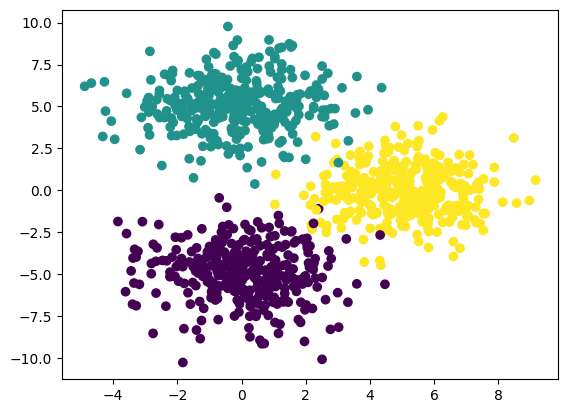

In [8]:
plt.scatter(X[:,0],X[:,1], c=y)
plt.show()

In [9]:
X[:10]

array([[ 2.4693187 , -1.92591103],
       [ 1.54390015,  8.5409378 ],
       [ 0.2277668 , -8.20193535],
       [ 4.25336657,  0.23603526],
       [ 0.83029015, -7.45409573],
       [-0.8432805 ,  6.93943103],
       [ 5.21702409,  0.42490179],
       [ 5.37533742, -0.06363402],
       [-1.29192871, -4.38369422],
       [ 0.99862151,  4.4833889 ]])

In [10]:
y[:10]

array([2, 1, 0, 2, 0, 1, 2, 2, 0, 1])

**Note** that we skip the part of one hot encoding using to_categorical in keras, we just need to
pass the class index targets into the loss function and PyTorch will take care of the rest.

In [11]:
import torch
import torch.nn.functional as F
y_torch = torch.tensor(y)
X_torch = torch.tensor(X)
Y_torch = F.one_hot(y_torch, num_classes=3)

**Now** We prepare the data with a split into train/test with ration 2:1 using Sklearn train_test_split, random seed is initialized to 1

In [12]:
X_train, X_test, y_train, y_test=train_test_split(X_torch,y_torch,test_size=0.33,random_state=1)

**Note** We create a model with 3 layers, activations are ReLu and we add dropout regularizations. Last activation is softmax

In [ ]:
model = torch.nn.Sequential(
    torch.nn.Linear(2, 6),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(6, 6),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(6, 3),
    torch.nn.Softmax(dim=1))

**Note** we now define the loss (crossentropy), the optimizer (adam) and the performance metrics, and we print the model

In [14]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), eps=1e-07) # we set eps to match Keras!

**Note** Now we print the summary of the network we just created.

In [15]:
from torchsummary import summary
input_shape = X_train.shape
summary(model, input_shape)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 670, 6]              18
              ReLU-2               [-1, 670, 6]               0
           Dropout-3               [-1, 670, 6]               0
            Linear-4               [-1, 670, 6]              42
              ReLU-5               [-1, 670, 6]               0
           Dropout-6               [-1, 670, 6]               0
            Linear-7               [-1, 670, 3]              21
           Softmax-8               [-1, 670, 3]               0
Total params: 81
Trainable params: 81
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.21
Params size (MB): 0.00
Estimated Total Size (MB): 0.22
----------------------------------------------------------------


**Note** convert the numpy data into tensors and create a data loader
which creates and iterator of batches of data.

In [16]:
train_dataset = torch.utils.data.TensorDataset(X_train,y_train) # create your datset
test_dataset = torch.utils.data.TensorDataset(X_test,y_test) # create your datset

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                          shuffle=True, num_workers=0)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64,
                                         shuffle=True, num_workers=0)

**Note** Now we define the two functions, one for training and another for testing the accuracy
of the trained network on test samples.

In [18]:
#Function to train the model with train dataset and print the training accuracy for every 10 batches.
def train(epochs):
  for epoch in range(50):  # loop over the dataset multiple times
    accuracy = 0.0
    total = 0.0
    running_loss = 0.0
    for i, data in enumerate(trainloader,0): #
        # zero the parameter gradients
        inputs, labels = data
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.float())
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()



        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0


  print('Finished Training')

# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy(): 

    model.eval() # Switch to evaluation mode (turns off dropout)
    accuracy = 0.0
    total = 0.0

    with torch.no_grad(): # No gradient calculation (faster, less memory)
        for data in testloader:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = model(images.float())
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)

**Note** we now display accuracy on train and test

In [19]:
train_acc = train(50)
test_acc = testAccuracy()
print('training_accuracy:', train_acc)
print('testing_accuracy:', test_acc)

[1,    10] loss: 1.140
[2,    10] loss: 1.123
[3,    10] loss: 1.098
[4,    10] loss: 1.072
[5,    10] loss: 1.050
[6,    10] loss: 1.020
[7,    10] loss: 0.994
[8,    10] loss: 0.978
[9,    10] loss: 0.960
[10,    10] loss: 0.944
[11,    10] loss: 0.934
[12,    10] loss: 0.908
[13,    10] loss: 0.895
[14,    10] loss: 0.880
[15,    10] loss: 0.866
[16,    10] loss: 0.848
[17,    10] loss: 0.839
[18,    10] loss: 0.829
[19,    10] loss: 0.810
[20,    10] loss: 0.795
[21,    10] loss: 0.782
[22,    10] loss: 0.771
[23,    10] loss: 0.765
[24,    10] loss: 0.762
[25,    10] loss: 0.750
[26,    10] loss: 0.732
[27,    10] loss: 0.738
[28,    10] loss: 0.724
[29,    10] loss: 0.712
[30,    10] loss: 0.712
[31,    10] loss: 0.720
[32,    10] loss: 0.709
[33,    10] loss: 0.692
[34,    10] loss: 0.706
[35,    10] loss: 0.720
[36,    10] loss: 0.714
[37,    10] loss: 0.694
[38,    10] loss: 0.682
[39,    10] loss: 0.694
[40,    10] loss: 0.696
[41,    10] loss: 0.703
[42,    10] loss: 0.692
[

##### key insight comparison between keras and torch
###### Keras run starts slowly with high loss and low accuracy, then accelerates sharply. Torch drops loss steadily from the start, showing smoother convergence. Keras begins around loss ≈3.1 and crawls down to ≈0.48 on the last epoch, while Torch moves gradually from ≈1.14 to ≈0.69.

**Note** if you fit again the model may continue to train

If you want to display the result every 10 epochs, you could use the following kind of loops
```
for i in range(5):
    model.fit(X_train, y_train, epochs=10, batch_size=64,verbose=0)
    _, train_acc = model.evaluate(X_train, y_train, batch_size=64)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=64)
    print('training_accuracy, epoch number ', i*10+ 10,' : ', train_acc)
    print('testing_accuracy, epoch number ', i*10+ 10,' : ', test_acc,'\n')
```

**Question**
Use this procedure to compare the behavior of different optimizers available on Pytorch, check this page
<https://pytorch.org/docs/stable/optim.html>
Try to compare the behavior of: SGD, RMSprop, Adam, Adadelta, Adagrad
Have a look to the available parameters

In [ ]:
optimizers = {
    "SGD":      lambda: torch.optim.SGD(model.parameters(), lr=0.05),
    "RMSprop":  lambda: torch.optim.RMSprop(model.parameters(), lr=0.01),
    "Adam":     lambda: torch.optim.Adam(model.parameters(), lr=0.01),
    "Adadelta": lambda: torch.optim.Adadelta(model.parameters(), lr=1.0),
    "Adagrad":  lambda: torch.optim.Adagrad(model.parameters(), lr=0.01)}

def train_for_10_epochs():
    model.train()
    for epoch in range(10):
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

# evaluation helpers
def accuracy(loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            out = model(x.float())
            _, pred = torch.max(out, 1)
            total += y.size(0)
            correct += (pred == y).sum().item()
    return 100 * correct / total

# main comparison loop
for name, opt_func in optimizers.items():
    print(f"\nOptimizer: {name}")
    
    # reinitialize model to same architecture for comparison
    model = torch.nn.Sequential(
        torch.nn.Linear(2, 6),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.2),
        torch.nn.Linear(6, 6),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.2),
        torch.nn.Linear(6, 3),
        torch.nn.Softmax(dim=1)
    )
    
    optimizer = opt_func()
    
    for step in range(5):  # 5 blocks * 10 epochs = 50 epochs
        train_for_10_epochs()
        train_acc = accuracy(trainloader)
        test_acc  = accuracy(testloader)
        print(f"Epoch {10*(step+1)} - Train: {train_acc:.2f}% | Test: {test_acc:.2f}%")


Optimizer: SGD
Epoch 10 - Train: 67.01% | Test: 64.55%
Epoch 20 - Train: 98.21% | Test: 95.76%
Epoch 30 - Train: 99.25% | Test: 96.97%
Epoch 40 - Train: 99.25% | Test: 98.18%
Epoch 50 - Train: 99.10% | Test: 98.48%

Optimizer: RMSprop
Epoch 10 - Train: 99.40% | Test: 98.79%
Epoch 20 - Train: 99.55% | Test: 98.18%
Epoch 30 - Train: 99.55% | Test: 98.48%
Epoch 40 - Train: 99.55% | Test: 98.48%
Epoch 50 - Train: 99.55% | Test: 98.48%

Optimizer: Adam
Epoch 10 - Train: 99.10% | Test: 98.48%
Epoch 20 - Train: 99.40% | Test: 98.18%
Epoch 30 - Train: 99.40% | Test: 98.18%
Epoch 40 - Train: 99.25% | Test: 98.48%
Epoch 50 - Train: 98.96% | Test: 98.18%

Optimizer: Adadelta
Epoch 10 - Train: 98.81% | Test: 98.18%
Epoch 20 - Train: 98.96% | Test: 97.88%
Epoch 30 - Train: 98.96% | Test: 98.18%
Epoch 40 - Train: 98.96% | Test: 98.18%
Epoch 50 - Train: 99.10% | Test: 98.18%

Optimizer: Adagrad
Epoch 10 - Train: 99.40% | Test: 98.48%
Epoch 20 - Train: 99.10% | Test: 98.18%
Epoch 30 - Train: 98.96% |

**Question** Using your favorite optimizer, try to change the architecture by simplifying or complexifying it, how the performance evolves?
Objective: Learn to add normalization layers, dropout, L1/L2 regularization.

**Final Question** Write down the similarities and differences between torch and keras version of the notebooks below.


Using RMSprop Optimizer

In [30]:
architectures = {
    "Simple": torch.nn.Sequential(
        torch.nn.Linear(2, 3), # Simple 2 inputs and 3 outputs
        torch.nn.Softmax(dim=1)
    ),

    "Deeper": torch.nn.Sequential(
        torch.nn.Linear(2, 16), # Deeper architecture with 2 inputs and 16 hidden units
        torch.nn.ReLU(),
        torch.nn.Linear(16, 32), # hidden layer with 32 units
        torch.nn.ReLU(),
        torch.nn.Dropout(0.2),
        torch.nn.Linear(32, 3), # output layer with 3 units
        torch.nn.Softmax(dim=1)),

    "BatchNorm": torch.nn.Sequential(
        torch.nn.Linear(2, 16), # Hidden layer with 16 units
        torch.nn.BatchNorm1d(16), # Normalization layer
        torch.nn.ReLU(),
        torch.nn.Linear(16, 16), # Hidden layer with 16 units
        torch.nn.BatchNorm1d(16),
        torch.nn.ReLU(),
        torch.nn.Linear(16, 3), # Output layer with 3 units
        torch.nn.Softmax(dim=1)
    ),

    "L2_Reg": torch.nn.Sequential(
        torch.nn.Linear(2, 6),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.2),
        torch.nn.Linear(6, 6),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.2),
        torch.nn.Linear(6, 3),
        torch.nn.Softmax(dim=1)),

    "High_Dropout": torch.nn.Sequential(
        torch.nn.Linear(2, 6),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(6, 6),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(6, 3),
        torch.nn.Softmax(dim=1)
    )
}

def train_for_10_epochs():
    model.train()
    for _ in range(10):
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

def accuracy(loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            out = model(x.float())
            _, pred = torch.max(out, 1)
            total += y.size(0)
            correct += (pred == y).sum().item()
    return 100 * correct / total

for name, arch in architectures.items():
    print(f"\n Architecture: {name}")
    model = arch
    if name == "L2_Reg":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, weight_decay=1e-3)
    else:
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)

    for step in range(5):  # 5 * 10 = 50 epochs
        train_for_10_epochs()
        tr = accuracy(trainloader)
        te = accuracy(testloader)
        print(f"Epoch {10*(step+1)} - Train: {tr:.2f}% | Test: {te:.2f}%")



 Architecture: Simple
Epoch 10 - Train: 99.25% | Test: 98.48%
Epoch 20 - Train: 99.25% | Test: 98.48%
Epoch 30 - Train: 99.40% | Test: 98.48%
Epoch 40 - Train: 99.25% | Test: 98.18%
Epoch 50 - Train: 99.25% | Test: 98.18%

 Architecture: Deeper
Epoch 10 - Train: 99.55% | Test: 98.18%
Epoch 20 - Train: 99.40% | Test: 98.48%
Epoch 30 - Train: 99.55% | Test: 98.48%
Epoch 40 - Train: 99.55% | Test: 98.18%
Epoch 50 - Train: 98.81% | Test: 97.58%

 Architecture: BatchNorm
Epoch 10 - Train: 98.81% | Test: 97.88%
Epoch 20 - Train: 98.81% | Test: 97.27%
Epoch 30 - Train: 99.40% | Test: 98.48%
Epoch 40 - Train: 98.81% | Test: 98.48%
Epoch 50 - Train: 99.25% | Test: 98.48%

 Architecture: L2_Reg
Epoch 10 - Train: 99.40% | Test: 98.48%
Epoch 20 - Train: 99.40% | Test: 98.48%
Epoch 30 - Train: 99.55% | Test: 98.18%
Epoch 40 - Train: 99.40% | Test: 98.18%
Epoch 50 - Train: 99.55% | Test: 98.48%

 Architecture: High_Dropout
Epoch 10 - Train: 98.96% | Test: 98.79%
Epoch 20 - Train: 99.40% | Test: 98.

### Further analysis

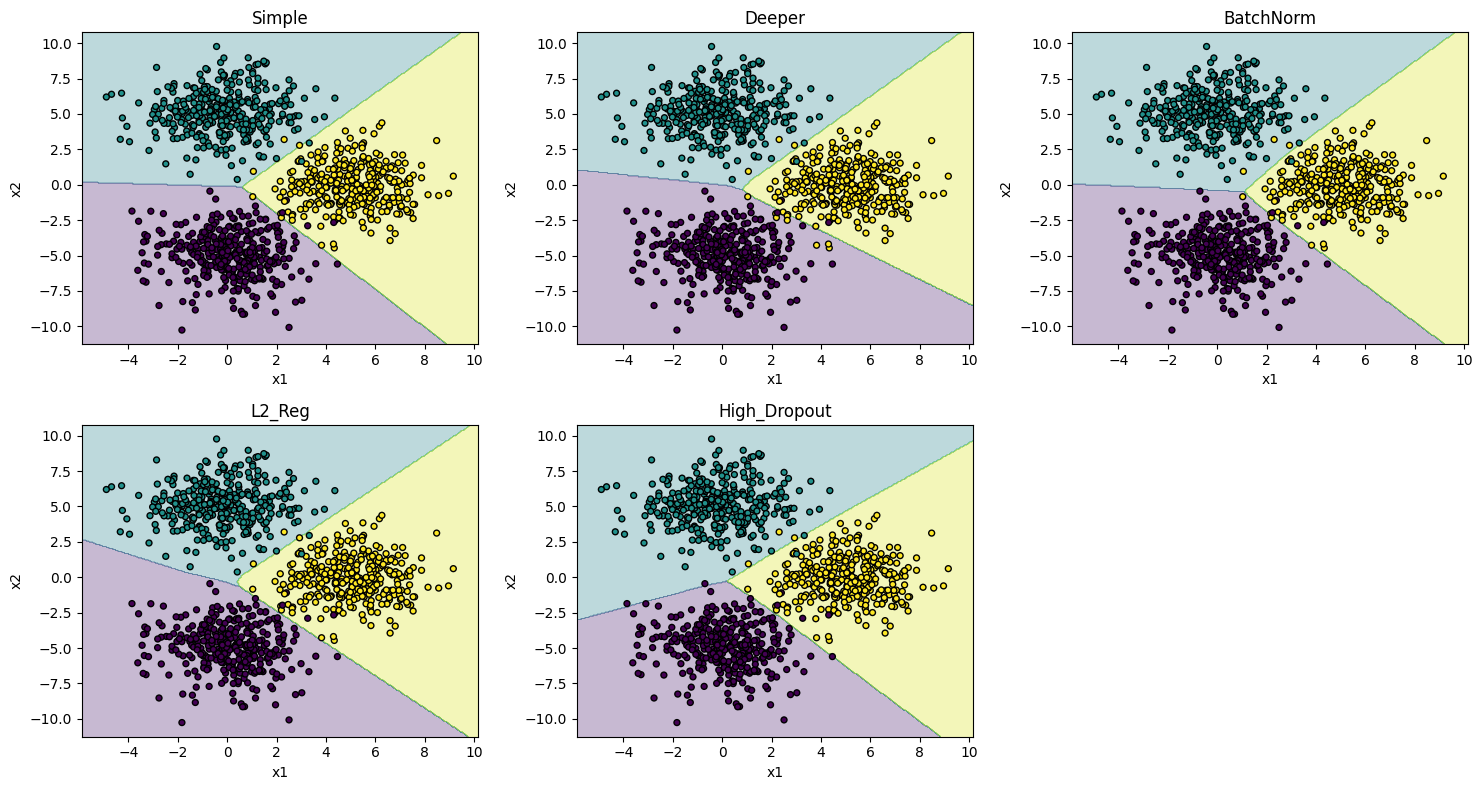

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def decision_map(model, X):
    model.eval()
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )

    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid).float()

    with torch.no_grad():
        out = model(grid_tensor)
        _, Z = torch.max(out, 1)
        Z = Z.numpy().reshape(xx.shape)

    return xx, yy, Z

# subplots for each architecture
cols = 3
rows = int(np.ceil(len(architectures) / cols))
plt.figure(figsize=(15, 4 * rows))

idx = 1
for name, arch in architectures.items():
    xx, yy, Z = decision_map(arch, X)

    plt.subplot(rows, cols, idx)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:,0], X[:,1], c=y, s=18, edgecolor='k')
    plt.title(name)
    plt.xlabel("x1")
    plt.ylabel("x2")
    idx += 1

plt.tight_layout()
plt.show()


###### All architectures produced almost identical decision boundaries because this dataset is clean and easily separable. Even the simplest linear model classified the three Gaussian clusters correctly. Increasing complexity with deeper layers, batch normalization, or regularization did not materially change outcomes. There is no strong non-linear structure here, so capacity and stabilization tricks do not meaningfully alter performance.

###### Basically on simple, well-separated data, model sophistication adds no benefit. Deep networks, dropout, and batchnorm only show advantages when data is noisy or has complex, non-linear structure. Here, the problem is already solved with a linear boundary, so every architecture converged to the same decision regions.

Answer to Final Question 

#### Despite different loss scales and optimization trajectories, both frameworks converged to the approximatelysame test accuracy (98.48%), demonstrating that; Framework choice becomes a matter of preference rather than performance - both PyTorch and Keras delivered identical results despite different internal optimization behaviors. The key is understanding each framework's strengths and default behaviors.

Both frameworks reached the same conclusion: this synthetic 2-D blob problem is simple enough that almost any sensible network architecture converges to ~98–99% accuracy. In both notebooks, increasing model depth or adding dropout and L2 barely changed final performance. Complexity did not buy meaningful gains because the clusters are clean and linearly separable. The pattern of results is consistent across Torch and Keras runs.

Key differences sit in workflow style, not outcomes. PyTorch required explicit tensor conversion, dataloaders, manual training loops, and manual accuracy logic. Keras handled one-hot encoding automatically, managed batches internally through `fit`, and provided built-in evaluation utilities, which sped up scripting. In Torch, forward/backward/step logic was written explicitly, and loss behaved more steadily over epochs. In Keras, training was more “hands-off,” with more automatic features, but learning curves started slower. Both libraries produced equivalent decision boundaries and learned the same structure; Torch offered lower-level control, while Keras offered compact high-level training routines.
